# Vertical access

This notebook tests the developement of the `CurveCWSFourier` class, and the related objective and penalty functions to optimize a vertical access port to the device.

In [1]:
from simsopt._core import load
from simsopt.geo import SurfaceRZFourier
from simsopt.geo import VerticalPortDiscrete

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

%matplotlib widget

In [2]:
# Load the surface, assumed fixed in this notebook. 
surf = SurfaceRZFourier.from_vmec_input( 'input.scaled' )

nfp = surf.nfp
qpts_phi = np.linspace(0, 1/(2*nfp), 8)
qpts_theta = np.linspace(0, 1, 32)

vessel = SurfaceRZFourier(
    nfp = surf.nfp,
    mpol = surf.mpol,
    ntor = surf.ntor,
    stellsym = surf.stellsym,
    quadpoints_phi=qpts_phi,
    quadpoints_theta=qpts_theta,
    dofs = surf.dofs
)

bs = load( 'coils.wiedman.json' )
ncoils = 5
curves = [c.curve for c in bs.coils[0:2*ncoils] + bs.coils[-ncoils:]]
#curves = [c.curve for c in bs.coils[-ncoils:]]


## Vertical Port Discrete

We test here `VerticalPortDiscrete`. This class is the "naive" implementation of a vertical port. It searches for the location on the surface where the largest circle in the XY plane can fit within the "shadow" of the vessel boundary on the XY plane, and withou touching any coils.

In [3]:
dvport = VerticalPortDiscrete( vessel, curves=curves )

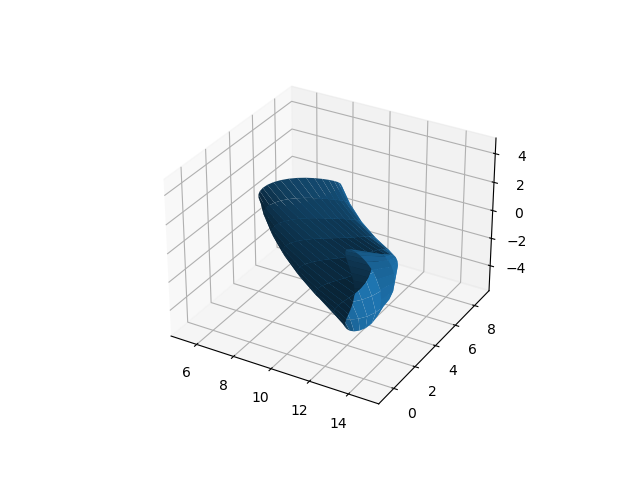

Text(0.10787434422876362, 0.014452421710067012, 'z')

In [4]:
# We only need one half field period of the surface, and the surrounding coils
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
vessel.plot( ax=ax, close=True )
for c in dvport.curves:
    c.plot(ax=ax, show=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

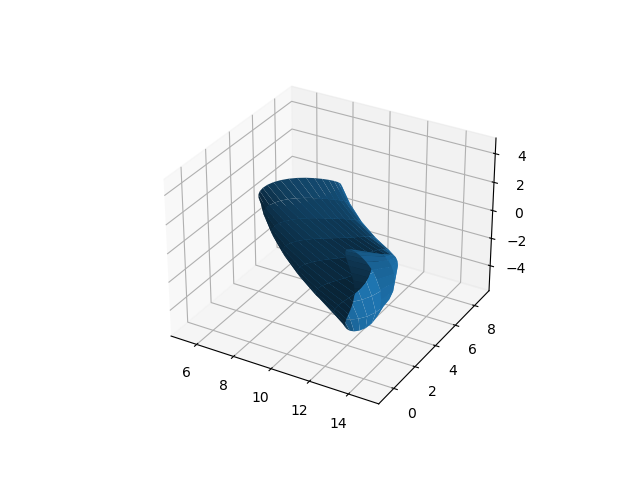

In [5]:
# Reduce the number of points on the surface. We check that we indeed isolate the points on the upper half of the device...
phi_ind = dvport.phi_ind
theta_ind = dvport.theta_ind
g = dvport.gamma_surf

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
vessel.plot( ax=ax, close=True )
ax.scatter( g[phi_ind, theta_ind, 0], g[phi_ind, theta_ind, 1], g[phi_ind, theta_ind, 2], color='r' )

ax.set_aspect('equal')

In [6]:
rport, iphi, itheta, ii = dvport.find_max_port_size_and_position()
print('rport = ', rport)

rport =  0.800243735956346


Text(0, 0.5, 'y')

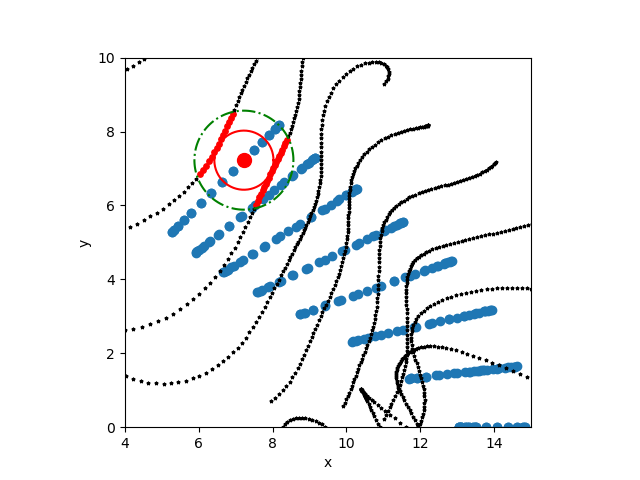

In [7]:
xx = dvport.gamma_surf.reshape((-1,3))[:,0]
yy = dvport.gamma_surf.reshape((-1,3))[:,1]

fig, ax = plt.subplots()
ax.scatter(xx,yy)

xp = dvport.gamma_surf[iphi,itheta,0]
yp = dvport.gamma_surf[iphi,itheta,1]
ax.scatter(xp, yp, s=100, marker='o', color='r')

l = np.linspace(0,2*np.pi,128,endpoint=True)
ax.plot(xp+rport*np.cos(l), yp+rport*np.sin(l), color='r')

dmax = dvport.dmax[ii]
ax.plot(xp+dmax*np.cos(l), yp+dmax*np.sin(l), color='g', linestyle='-.')

xflat = dvport.gamma_surf.reshape((-1,3))

for c in dvport.curves:
    g = c.gamma()
    zcurves = g[:,2]

    surf_dist_to_pt = np.sqrt((xx-xflat[:,0])**2 + (yy-xflat[:,1])**2)
    ind = np.where(surf_dist_to_pt<=dvport.dmax[ii])
    mean_z = np.mean( xflat[ind,2] )

    ind = np.where( zcurves>mean_z )[0]
    g = g[ind,:]

    
    d_to_port = np.sqrt((xp-g[:,0])**2+(yp-g[:,1])**2)
    ind = np.where(d_to_port<=dvport.dmax[ii])[0]
    ax.scatter(g[ind,0], g[ind,1], color='r', marker='o', s=15)
    
    ind = np.where(d_to_port>dvport.dmax[ii])
    ax.scatter(g[ind,0], g[ind,1], color='k', marker='*', s=5)

ax.set_xlim(4,15)
ax.set_ylim(0,10)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')


## CurveCWSFourier

This class represents a curve that lies on a surface. 

In [8]:
from simsopt.geo import CurveCWSFourier

In [9]:
order = 2
qpts = 128
curve_cws = CurveCWSFourier(
    qpts,
    order,
    vessel
)

curve_cws.set('phic(0)', 0.0625)
curve_cws.set('phic(1)', 0.025)
curve_cws.set('thetac(0)', 0.3)
curve_cws.set('thetas(1)', 0.25)
#curve_cws.set('thetas(2)', -0.15)

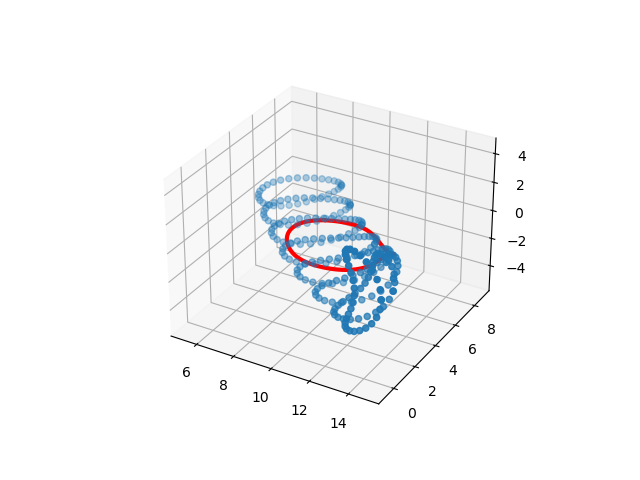

<Axes3D: >

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
g = vessel.gamma()
ax.scatter(g[...,0],g[...,1],g[...,2])
ax=plt.gca()
curve_cws.plot(ax=ax,color='r',linewidth=3)

Text(0, 0.5, 'y')

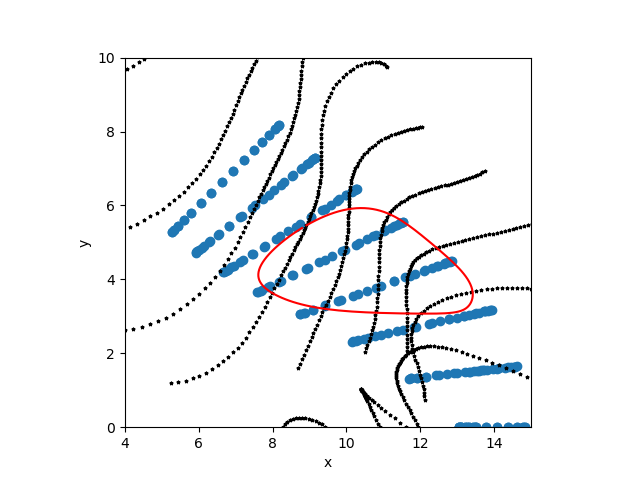

In [11]:
xx = dvport.gamma_surf.reshape((-1,3))[:,0]
yy = dvport.gamma_surf.reshape((-1,3))[:,1]

fig, ax = plt.subplots()
ax.scatter(xx,yy)

g = curve_cws.gamma()
ax.plot(g[:,0], g[:,1], color='r')

for c in curves:
    g = c.gamma()
    ind = np.where(g[:,2]>0)
    ax.scatter(g[ind,0], g[ind,1], color='k', marker='*', s=5)

ax.set_xlim(4,15)
ax.set_ylim(0,10)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Objectives


In [12]:
from simsopt.geo import EnclosedXYArea, CurveCurveXYdistance, CurveXYConvexity, ToroidalAngleConstraint, UpwardFacingPort

## EnclosedXYArea

As the name suggests, this is an objective for the area spanned by the curve on the XY plane. We multiply it by z-component of the unit normal to the surface; the function is thus negative if the curve lies on the top of the vessel, positive if it lies on the bottom of the vessel, and a sum of both (i.e. a small value) if it wraps around it.

In [13]:
Jxyarea = EnclosedXYArea( curve_cws )

In [14]:
Jxyarea.J()

Array(11.92591782, dtype=float64)

In [15]:
Jxyarea.dJ()

array([ 18.40009013, 446.54862934,  38.39443841, -51.54786487,
       111.98459339,  20.96852454,  -5.15478649,  -9.7700652 ,
        26.6895351 ,  -1.99943483])

Text(0.5, 0, '$\\epsilon$')

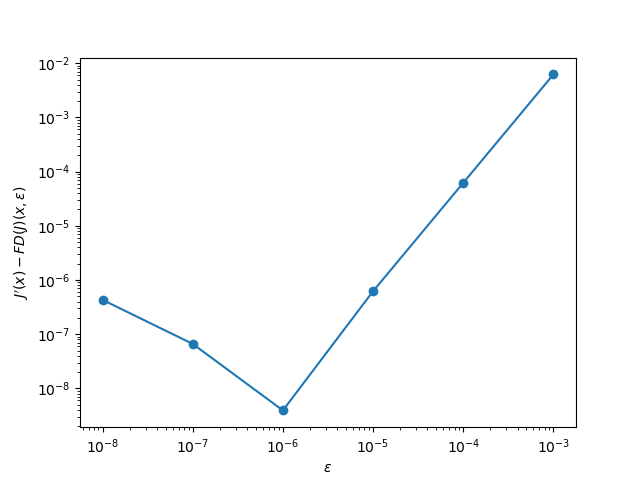

In [16]:
def f(x):
    Jxyarea.x = x
    return Jxyarea.J(), Jxyarea.dJ()

dofs = Jxyarea.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8]
myerr=[]
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh )

plt.figure()
plt.loglog(myeps, np.abs(myerr), marker='o')
plt.ylabel(r"$J'(x)-FD(J)(x,\epsilon)$")
plt.xlabel(r"$\epsilon$")

## CurveCurveXYdistance

This penalty penalises curves that are too close to the port boundary once projected on the XY-plane. This is heavily inspired from the implementation of `CurveCurveDistance`, excepted that here, only the distance to `curve_cws` is taken into account, the distance is in the XY plane, and only points that have a z-component higher than the curve_cws z-component are accounted for (this effectively removes curve elements below the plasma)

In [17]:
Jccxydist = CurveCurveXYdistance( curves, curve_cws, .1 )

In [18]:
for c in curves:
    c.unfix_all()

In [19]:
Jccxydist.J()

Array(0.89597053, dtype=float64)

Text(0.5, 0, '$\\epsilon$')

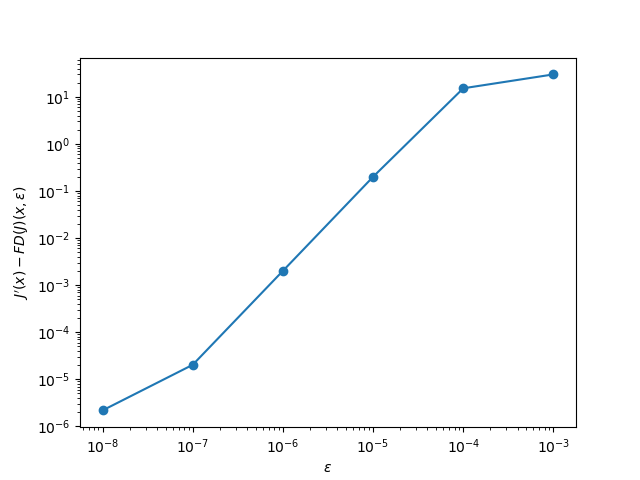

In [20]:
def f(x):
    Jccxydist.x = x
    return Jccxydist.J(), Jccxydist.dJ()

dofs = Jccxydist.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8]
myerr=[]
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh )

plt.figure()
plt.loglog(myeps, np.abs(myerr), marker='o')
plt.ylabel(r"$J'(x)-FD(J)(x,\epsilon)$")
plt.xlabel(r"$\epsilon$")

In [21]:
for c in curves:
    c.fix_all()
curves[6].unfix_all()
Jccxydist.dJ()

array([ 2.97879675e+02, -2.00771938e+02, -1.18736743e+01,  3.58887641e+01,
        8.12099133e+01, -1.49742047e+01, -1.05390311e+01, -2.37411668e+01,
       -2.52950914e+00,  1.79635814e+01,  2.20832299e+00,  1.83243743e+00,
       -1.22033776e+00, -2.01696217e+00, -8.35013686e-01,  4.38367378e-01,
        2.11277583e+00,  1.47315445e+00, -1.54650579e+00, -2.10545708e+00,
       -3.17862391e-01,  9.55089872e-01,  1.92160694e+00,  1.05885440e+00,
       -1.90727229e+00, -2.21161394e+00,  1.83373093e-01,  1.37367246e+00,
        1.76557408e+00,  7.26517824e-01, -2.09794011e+00, -7.78625953e-01,
       -7.14777051e-01,  6.68441437e-03, -4.05065971e-02,  5.44952437e-01,
        3.25623580e-01,  1.70187957e-01,  3.70885112e-01, -1.25411428e-01,
        2.33878579e-03, -5.92905053e-01, -7.66479929e-01, -4.07205399e-02,
       -1.54771279e-02,  8.29158120e-01,  7.51530891e-01, -1.65296051e-02,
        7.72965387e-03, -5.50783774e-01, -2.86166015e-01, -1.28935281e-01,
        1.31807652e-01,  

## Jconvex

This penalty penalises curves that are not convex in the XY plane. 

In [22]:
Jconvex = CurveXYConvexity( curve_cws )

In [23]:
Jconvex.J()

Array(1.19258012, dtype=float64)

Text(0.5, 0, '$\\epsilon$')

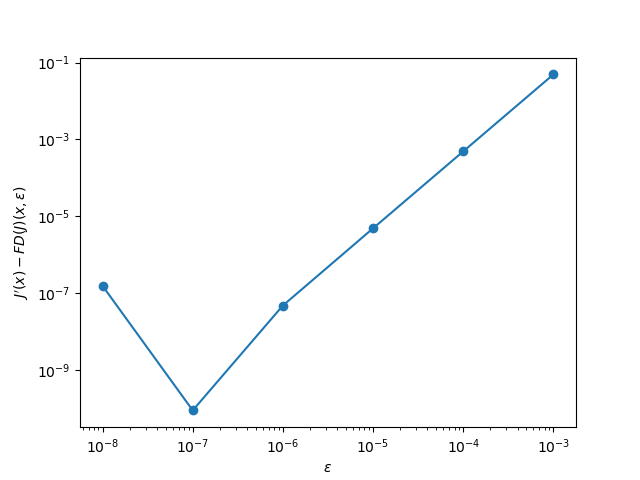

In [24]:
def f(x):
    Jconvex.x = x
    return Jconvex.J(), Jconvex.dJ()

dofs = Jconvex.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8]
myerr=[]
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh )

plt.figure()
plt.loglog(myeps, np.abs(myerr), marker='o')
plt.ylabel(r"$J'(x)-FD(J)(x,\epsilon)$")
plt.xlabel(r"$\epsilon$")

## Toroidal angle constraint

In [25]:
Jphi = ToroidalAngleConstraint(curve_cws, 0, 'max')
Jphi.J()

Array(0.3022564, dtype=float64)

Text(0.5, 0, '$\\epsilon$')

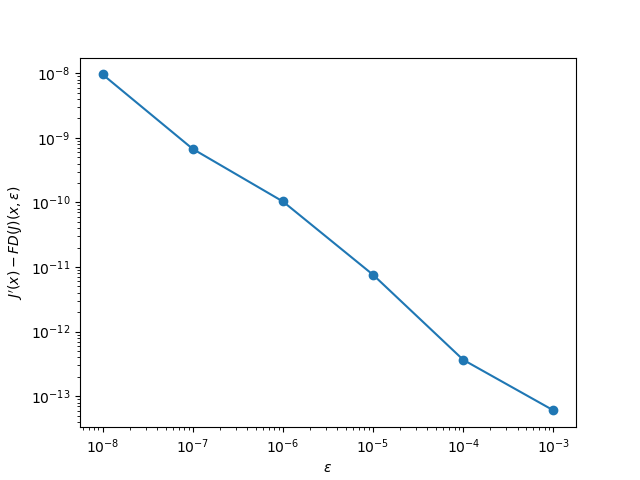

In [26]:
def f(x):
    Jphi.x = x
    return Jphi.J(), Jphi.dJ()

dofs = Jphi.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8]
myerr=[]
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh )

plt.figure()
plt.loglog(myeps, np.abs(myerr), marker='o')
plt.ylabel(r"$J'(x)-FD(J)(x,\epsilon)$")
plt.xlabel(r"$\epsilon$")

## Upward facing port

In [27]:
Jufp = UpwardFacingPort(curve_cws)
Jufp.J()

Array(0.1120447, dtype=float64)

Text(0.5, 0, '$\\epsilon$')

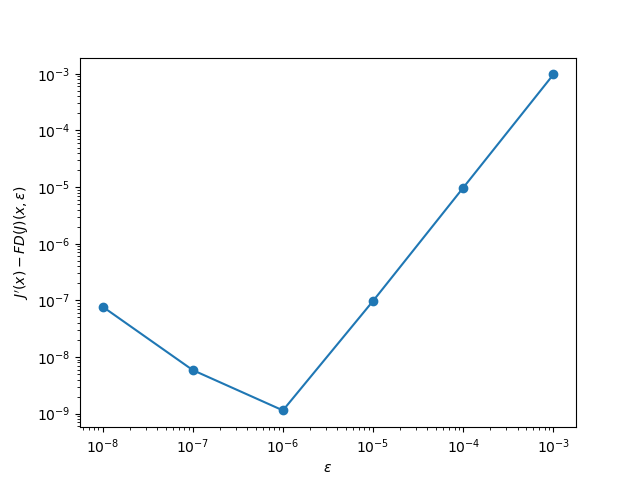

In [28]:
def f(x):
    Jufp.x = x
    return Jufp.J(), Jufp.dJ()

dofs = Jufp.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8]
myerr=[]
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh )

plt.figure()
plt.loglog(myeps, np.abs(myerr), marker='o')
plt.ylabel(r"$J'(x)-FD(J)(x,\epsilon)$")
plt.xlabel(r"$\epsilon$")

# Test optimization

We now perform a very simple optimization of the port size. The target function is 
$$
J = A_{xy}(C_0) + J_{convex}(C_0) + J_{xy_cc_dist}(C_0,\mathbf{C}),
$$
where $C_0$ is the port boundary, and $\mathbf{C}$ is an array containing all the coils. We fix the boundary dofs and the coils dofs, only the port boundary is a free parameter. We initialize the port close to where the maximum port size was found using the vertical port discrete class.

In [29]:
from scipy.optimize import minimize
from simsopt.geo import ArclengthVariation

Text(0, 0.5, 'y')

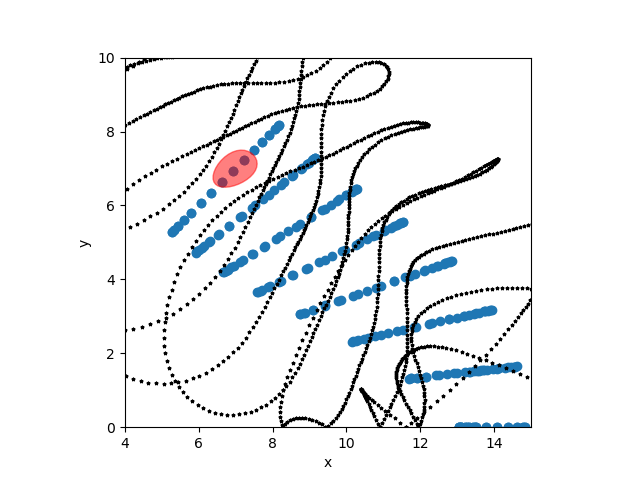

In [30]:
order = 1
qpts = 32
curve_cws = CurveCWSFourier(
    qpts,
    order,
    vessel
)

curve_cws.set('phic(0)', 0.125)
curve_cws.set('phic(1)', 0.007)
curve_cws.set('thetac(0)', 0.22)
curve_cws.set('thetas(1)', 0.05)

xx = dvport.gamma_surf.reshape((-1,3))[:,0]
yy = dvport.gamma_surf.reshape((-1,3))[:,1]

fig, ax = plt.subplots()
ax.scatter(xx,yy)


xflat = dvport.gamma_surf.reshape((-1,3))

for c in dvport.curves:
    g = c.gamma()
    
    #ax.scatter(g[:,0], g[:,1], color='r', marker='o', s=15)
    
    ind = np.where(d_to_port>dvport.dmax[ii])
    ax.scatter(g[:,0], g[:,1], color='k', marker='*', s=5)

g = curve_cws.gamma()
ax.fill(g[:,0], g[:,1], color='r', alpha=0.5)


ax.set_xlim(4,15)
ax.set_ylim(0,10)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')

In [31]:
# Define the objective function
bs = load( 'coils.wiedman.json' )
ncoils = 5
curves = [c.curve for c in bs.coils[0:2*ncoils] + bs.coils[-ncoils:]]


Jxyarea = EnclosedXYArea( curve_cws )
Jccxydist = CurveCurveXYdistance( curves, curve_cws, 0.1 )
Jconvex = CurveXYConvexity( curve_cws )
Jphimin = ToroidalAngleConstraint(curve_cws, -1/(4*surf.nfp), 'min')
Jphimax = ToroidalAngleConstraint(curve_cws, 3/(4*surf.nfp), 'max')
Jarc = ArclengthVariation( curve_cws )
Jufp = UpwardFacingPort(curve_cws)

wdd = 1E2
#wco = 0
#wph = 1E3
warc = 1E-1
wufp = 1E-1

J = -1*Jxyarea + wdd * Jccxydist + warc * Jarc + wufp*Jufp #+ wph * (Jphimin + Jphimax) + wco * Jconvex # #

def f(x, info={'Nfeval': 0}):
    info['Nfeval'] += 1
    
    J.x = x

    A = Jxyarea.J()
    CC = Jccxydist.J()
    convex = Jconvex.J()
    out = J.J()
    
    nf = info['Nfeval']
    outstr = f"Nfeval: {nf}::  J={out:.2E}, Area={A:.2E}, Coil-coil dist={CC:.2E}, Convex={convex:.2E}, Arclength={Jarc.J():.2E}, Jufp={Jufp.J():.2E}"
    if np.mod(nf,10)==0:
        outstr+="/n"
    print(outstr)
    
    return out, J.dJ()

In [32]:
Jxyarea.J()

Array(0.86486263, dtype=float64)

In [33]:
Jccxydist.J()

Array(0., dtype=float64)

In [34]:
Jconvex.J()

Array(0.03919139, dtype=float64)

In [35]:
Jarc.J()

0.30856966439221456

In [36]:
Jufp.J()

Array(0., dtype=float64)

In [37]:
for c in curves:
    c.fix_all()
curve_cws.unfix_all()

dofs = J.x
f(dofs, {'Nfeval':0})

Nfeval: 1::  J=-8.34E-01, Area=8.65E-01, Coil-coil dist=0.00E+00, Convex=3.92E-02, Arclength=3.09E-01, Jufp=0.00E+00


(Array(-0.83400567, dtype=float64),
 array([  -5.04904877, -129.04161575,   17.85422405,   -0.15834782,
           2.49959137,  -14.69723233]))

In [38]:
MAXITER = 1000
res = minimize(f, dofs, jac=True, args=({'Nfeval': 0}), method='L-BFGS-B', options={'maxiter': MAXITER, 'maxcor': 300}, tol=1e-8)

Nfeval: 1::  J=-8.34E-01, Area=8.65E-01, Coil-coil dist=0.00E+00, Convex=3.92E-02, Arclength=3.09E-01, Jufp=0.00E+00
Nfeval: 2::  J=3.71E+03, Area=2.30E+02, Coil-coil dist=2.62E+00, Convex=2.89E+03, Arclength=3.67E+04, Jufp=2.06E-01
Nfeval: 3::  J=2.45E+02, Area=4.65E+01, Coil-coil dist=0.00E+00, Convex=7.15E+01, Arclength=2.91E+03, Jufp=0.00E+00
Nfeval: 4::  J=7.20E+01, Area=2.75E+00, Coil-coil dist=7.42E-01, Convex=1.83E-03, Arclength=4.94E+00, Jufp=0.00E+00
Nfeval: 5::  J=-8.43E-01, Area=8.73E-01, Coil-coil dist=0.00E+00, Convex=3.88E-02, Arclength=3.04E-01, Jufp=0.00E+00
Nfeval: 6::  J=8.01E+01, Area=2.09E+00, Coil-coil dist=8.20E-01, Convex=1.70E-03, Arclength=2.12E+00, Jufp=0.00E+00
Nfeval: 7::  J=-8.43E-01, Area=8.74E-01, Coil-coil dist=0.00E+00, Convex=3.87E-02, Arclength=3.03E-01, Jufp=0.00E+00
Nfeval: 8::  J=5.72E+01, Area=1.67E+00, Coil-coil dist=5.88E-01, Convex=8.93E-03, Arclength=9.52E-01, Jufp=0.00E+00
Nfeval: 9::  J=-1.06E+00, Area=1.08E+00, Coil-coil dist=0.00E+00, Con

In [39]:
res.message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [40]:
Jccxydist.J()

Array(3.24961777e-06, dtype=float64)

In [41]:
Jxyarea.J()

Array(3.93579086, dtype=float64)

In [42]:
Jconvex.J()

Array(0.28104209, dtype=float64)

In [43]:
Jarc.J()

7.286574890284248

In [44]:
Jufp.J()

Array(0., dtype=float64)

Text(0, 0.5, 'y')

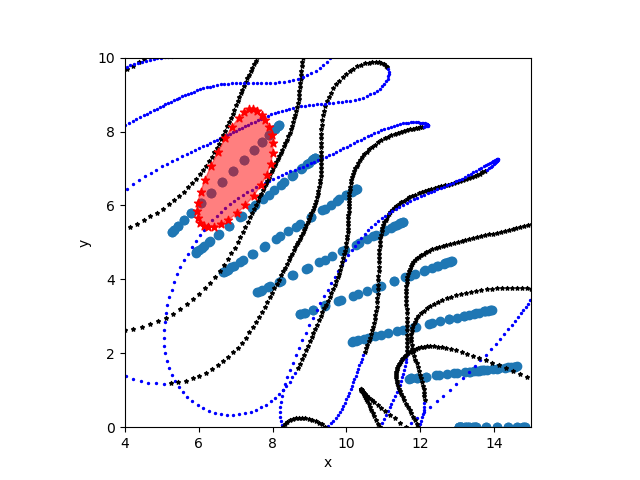

In [45]:
xx = dvport.gamma_surf.reshape((-1,3))[:,0]
yy = dvport.gamma_surf.reshape((-1,3))[:,1]

fig, ax = plt.subplots()
ax.scatter(xx,yy)

# xp = dvport.gamma_surf[iphi,itheta,0]
# yp = dvport.gamma_surf[iphi,itheta,1]
# ax.scatter(xp, yp, s=100, marker='o', color='r')

# l = np.linspace(0,2*np.pi,128,endpoint=True)
# ax.plot(xp+rport*np.cos(l), yp+rport*np.sin(l), color='r')

# dmax = dvport.dmax[ii]
# ax.plot(xp+dmax*np.cos(l), yp+dmax*np.sin(l), color='g', linestyle='-.')

xflat = dvport.gamma_surf.reshape((-1,3))

for c in dvport.curves:
    g = c.gamma()
    zcurves = g[:,2]

    surf_dist_to_pt = np.sqrt((xx-xflat[:,0])**2 + (yy-xflat[:,1])**2)
    ind = np.where(surf_dist_to_pt<=dvport.dmax[ii])
    mean_z = np.mean( xflat[ind,2] )

    ind = np.where( zcurves>0 )[0]
    ax.scatter(g[ind,0], g[ind,1], color='k', marker='*', s=8)
    ind = np.where( zcurves<0 )[0]
    ax.scatter(g[ind,0], g[ind,1], color='b', marker='o', s=2)


c = dvport.curves[3]
g = c.gamma()
zcurves = g[:,2]

surf_dist_to_pt = np.sqrt((xx-xflat[:,0])**2 + (yy-xflat[:,1])**2)
ind = np.where(surf_dist_to_pt<=dvport.dmax[ii])
mean_z = np.mean( xflat[ind,2] )

    

g = curve_cws.gamma()
ax.fill(g[:,0], g[:,1], color='r', alpha=0.5)
ax.scatter(g[:,0], g[:,1], color='r', marker='*')



c = curves[13]
g = c.gamma()
zcurves = g[:,2]

surf_dist_to_pt = np.sqrt((xx-xflat[:,0])**2 + (yy-xflat[:,1])**2)
ind = np.where(surf_dist_to_pt<=dvport.dmax[ii])
mean_z = np.mean( xflat[ind,2] )

# ind = np.where( zcurves>0 )[0]
# ax.scatter(g[ind,0], g[ind,1], color='r', marker='*', s=8)
# ind = np.where( zcurves<0 )[0]
# ax.scatter(g[ind,0], g[ind,1], color='r', marker='o', s=2)



ax.set_xlim(4,15)
ax.set_ylim(0,10)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')

Great! This seems to work as expected. We can now try a stage II optimization, where we target a larger port size while keeping the field error small...